In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 98% !important }<style>"))

# Analysis

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
ble = read_ble("../Data/ble.csv")
pin = read_pin("../Data/pin.csv")
testPin = read_pin("../Data/testPin.csv")

In [6]:
data = read_data("../Data/rssi_2.csv")
data.shape

All beacons: ['0117C55D14E4']
Selecting all


(63707, 19)

In [7]:
data[scanners] = min_max_scaling(data[scanners])

In [8]:
test = read_data("../Data/testRssi_2.csv")
test.shape

All beacons: ['0117C55D14E4']
Selecting all


(18771, 19)

In [9]:
test[scanners] = min_max_scaling(test[scanners])

## Train Validation Split

In [10]:
train, validation = train_validation_split(data)

In [11]:
train.shape

(50965, 19)

In [12]:
validation.shape

(12742, 19)

In [13]:
train.sort_values("time", inplace=True)
validation.sort_values("time", inplace=True)
test.sort_values("time", inplace=True)

In [14]:
rolling_win = 30
train_rolled = train.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
validation_rolled = validation.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
test_rolled = test.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()

In [15]:
train_rolled

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,NaN,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.440000,0.316667,NaN,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,NaN,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.454167,0.300000,NaN,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.454167,0.266667,NaN,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,NaN,0.308333,NaN,0.466667,0.383333,0.454167,0.283333,NaN,0.55


## Imputation
1. Forward fill

In [16]:
train_imputed = train_rolled.set_index("location").groupby("location").ffill()
train_imputed.reset_index(inplace=True)

In [17]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.440000,0.316667,0.1,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.300000,0.1,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.266667,0.1,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.308333,0.15,0.466667,0.383333,0.454167,0.283333,0.1,0.55


In [18]:
validation_imputed = validation_rolled.set_index("location").groupby("location").ffill()
validation_imputed.reset_index(inplace=True)

In [19]:
test_imputed = test_rolled.set_index("location").groupby("location").ffill()
test_imputed.reset_index(inplace=True)

In [20]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.440000,0.316667,0.1,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.300000,0.1,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.266667,0.1,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.308333,0.15,0.466667,0.383333,0.454167,0.283333,0.1,0.55


## Change Location to Coordinates

In [21]:
train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

In [22]:
validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

In [23]:
test_imputed["X"] = test_imputed["location"].apply(lambda x: testPin[x]["X"])
test_imputed["Y"] = test_imputed["location"].apply(lambda x: testPin[x]["Y"])

## Linear Imputation

In [24]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

In [25]:
linear_impute(train_imputed)
linear_impute(validation_imputed)
linear_impute(test_imputed)

In [26]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,V1_10,24997,0.466667,-77.349171,-79.493075,-65.687848,-72.664091,-81.222654,-83.756606,-72.345025,...,-79.883274,-89.790535,-70.185820,-65.376882,-75.251587,-78.768045,-95.74648,-73.006668,11.17660,5.29753
1,V1_10,24999,0.466667,-77.349171,-79.493075,-65.687848,-72.664091,-81.222654,-83.756606,-72.345025,...,-79.883274,-89.790535,-70.185820,0.666667,-75.251587,-78.768045,-95.74648,-73.006668,11.17660,5.29753
2,V1_10,25000,0.466667,0.400000,-79.493075,-65.687848,-72.664091,-81.222654,-83.756606,-72.345025,...,-79.883274,-89.790535,-70.185820,0.666667,-75.251587,-78.768045,-95.74648,-73.006668,11.17660,5.29753
3,V1_10,25001,0.466667,0.400000,-79.493075,0.566667,-72.664091,-81.222654,-83.756606,-72.345025,...,-79.883274,-89.790535,-70.185820,0.666667,-75.251587,-78.768045,-95.74648,-73.006668,11.17660,5.29753
4,V1_10,25002,0.483333,0.400000,-79.493075,0.566667,-72.664091,-81.222654,-83.756606,-72.345025,...,-79.883274,-89.790535,-70.185820,0.666667,-75.251587,-78.768045,-95.74648,-73.006668,11.17660,5.29753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.440000,0.316667,0.10000,0.550000,8.17867,5.28213
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.454167,0.300000,0.10000,0.550000,8.17867,5.28213
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.454167,0.266667,0.10000,0.550000,8.17867,5.28213
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.308333,0.150000,0.466667,0.383333,0.454167,0.283333,0.10000,0.550000,8.17867,5.28213


## Model Training

In [27]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [28]:
optimizer = tf.keras.optimizers.Adam(0.00001)
loss = "mse"
metrics = ["mae", "mse"]
batch_size = 32
epochs = 10000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss')
]

inputs = tf.keras.Input(shape=(17,))

x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

y = tf.keras.layers.Dense(128, activation='relu')(inputs)
y = tf.keras.layers.Dense(64, activation='relu')(y)
y = tf.keras.layers.Dense(32, activation='relu')(y)
y = tf.keras.layers.Dense(16, activation='relu')(y)
y = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)

outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
______________________________________________________________________________________________

In [30]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 50965 samples, validate on 18771 samples
Epoch 1/10000
50965/50965 [==============================] - 3s 67us/sample - loss: 164.5989 - mae: 10.3556 - mse: 164.5951 - val_loss: 127.0521 - val_mae: 8.6260 - val_mse: 127.0484
Epoch 2/10000
50965/50965 [==============================] - 3s 53us/sample - loss: 116.5767 - mae: 8.2117 - mse: 116.5728 - val_loss: 78.2140 - val_mae: 6.5674 - val_mse: 78.2102
Epoch 3/10000
50965/50965 [==============================] - 3s 50us/sample - loss: 49.0280 - mae: 4.8254 - mse: 49.0240 - val_loss: 34.1226 - val_mae: 4.2144 - val_mse: 34.1186
Epoch 4/10000
50965/50965 [==============================] - 2s 47us/sample - loss: 22.2027 - mae: 3.5882 - mse: 22.1987 - val_loss: 24.0358 - val_mae: 3.7695 - val_mse: 24.0318
Epoch 5/10000
50965/50965 [==============================] - 2s 49us/sample - loss: 17.7142 - mae: 3.3162 - mse: 17.7102 - val_loss: 22.4524 - val_mae: 3.4388 - val_mse: 22.4484
Epoch 6/10000
50965/50965 [==========================

Epoch 47/10000
50965/50965 [==============================] - 3s 53us/sample - loss: 1.2046 - mae: 0.8045 - mse: 1.2004 - val_loss: 55.3397 - val_mae: 2.4722 - val_mse: 55.3354
Epoch 48/10000
50965/50965 [==============================] - 3s 52us/sample - loss: 1.1889 - mae: 0.7985 - mse: 1.1846 - val_loss: 55.0698 - val_mae: 2.4538 - val_mse: 55.0655
Epoch 49/10000
50965/50965 [==============================] - 2s 49us/sample - loss: 1.1737 - mae: 0.7921 - mse: 1.1694 - val_loss: 54.0446 - val_mae: 2.4520 - val_mse: 54.0403
Epoch 50/10000
50965/50965 [==============================] - 3s 51us/sample - loss: 1.1574 - mae: 0.7855 - mse: 1.1531 - val_loss: 54.6566 - val_mae: 2.4407 - val_mse: 54.6523
Epoch 51/10000
50965/50965 [==============================] - 3s 53us/sample - loss: 1.1433 - mae: 0.7802 - mse: 1.1390 - val_loss: 54.0276 - val_mae: 2.4247 - val_mse: 54.0233
Epoch 52/10000
50965/50965 [==============================] - 2s 48us/sample - loss: 1.1289 - mae: 0.7740 - mse: 1.

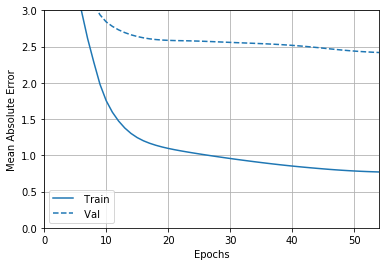

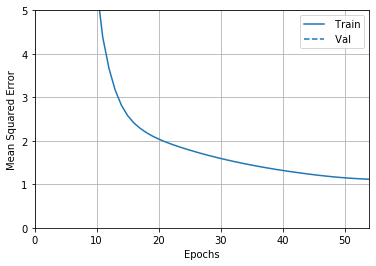

In [31]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('Mean Squared Error')

plt.show()

## Model Validation

In [32]:
def inv_scale(y):
    ret_y = np.copy(y)
    ret_y[:, 0] = ret_y[:, 0] * 33.5
    ret_y[:, 1] = ret_y[:, 1] * 16.8
    return ret_y

def average_distance_error(preds, y_test, scaled=False):
    if scaled:
        preds = inv_scale(preds)
        y_test = inv_scale(y_test)
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=1)))

12742/1 - 0s - loss: 30.2670 - mae: 2.1425 - mse: 59.5268
Validation loss: 59.53115315873569
Mean absolute error: 2.1424625
Mean squared error: 59.526836
Average distance error: 3.5766764078553486


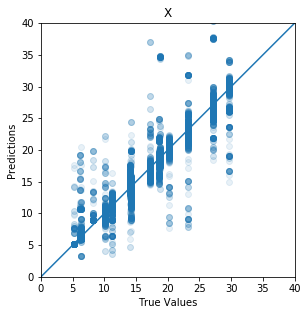

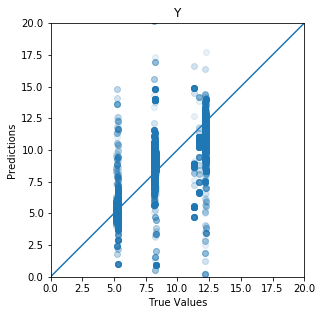

In [33]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Validation loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

## Model Testing

18771/1 - 0s - loss: 26.9860 - mae: 2.3899 - mse: 52.5762
Test loss: 52.58051570854153
Mean absolute error: 2.3898613
Mean squared error: 52.576183
Average distance error: 3.995635331227694


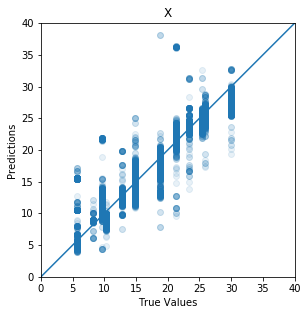

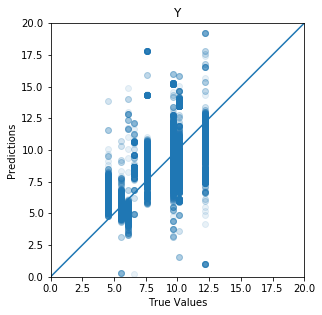

In [34]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

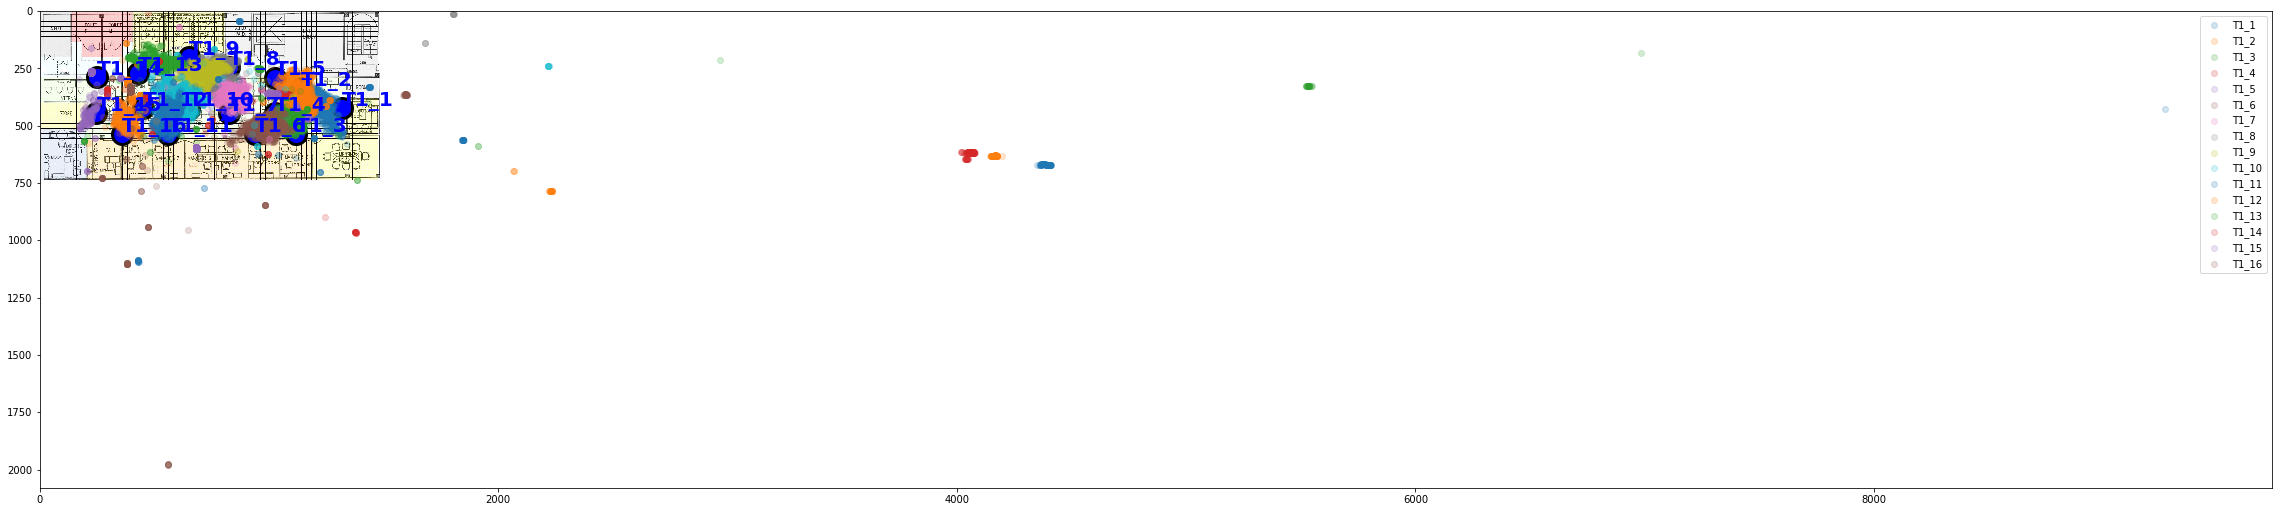

In [35]:
img =  mpimg.imread('../Map/main.png')
fingerprint_color = "r"
testdata_color = "b"
plt.figure(figsize=(40,40))
plt.imshow(img)

labels = ["V1_23", "V1_24", "V1_32", "V1_22", "V1_14", "V1_13", "V1_12", "V1_21", "V1_29", "V1_30", "V1_31", "V1_11", "V1_20", "V1_28", "V1_10", "V1_19", "V1_27", "V1_9", "V1_8", "V1_18", "V1_26"]
x = [27.151600, 29.594400, 29.689400, 23.153700, 23.169100, 20.171700, 17.173201, 18.712299, 18.691700, 23.244200, 27.133301, 14.063600, 14.159800, 14.250300, 11.176600, 10.162500, 10.141900, 8.178670, 5.180690, 6.164600, 6.255650]
y = [8.159480, 8.172020, 11.286000, 8.250140, 5.247920, 5.121330, 5.217130, 8.227330, 12.230300, 12.253700, 11.717700, 5.312350, 8.203950, 12.207500, 5.297530, 8.183420, 12.186400, 5.282130, 5.266730, 8.274090, 12.166400]
x = np.array(x) * 44
y = np.array(y) * 44

testLabels = ["T1_1", "T1_2", "T1_3", "T1_4", "T1_5", "T1_6", "T1_7", "T1_8", "T1_9", "T1_10", "T1_11", "T1_12", "T1_13", "T1_14", "T1_15", "T1_16"]
testX = [29.934250, 25.877805, 25.372470, 23.355726, 23.333564, 21.316819, 18.790348, 18.790348, 14.779021, 14.779021, 12.717952, 10.191480, 9.703916, 5.648265, 5.626103, 8.174736]
testY = [9.659024, 7.630801, 12.155781, 10.139037, 6.593112, 12.177943, 10.094712, 5.573659, 4.554205, 9.673634, 12.155781, 9.629310, 6.105547, 6.570950, 10.139037, 12.177943]
testX = np.array(testX) * 44
testY = np.array(testY) * 44

# plt.scatter(x, y, s=400, c=fingerprint_color, edgecolors="black", linewidths=3)
plt.scatter(testX, testY, s=400, c=testdata_color, edgecolors="black", linewidths=3)

# for i in range(len(labels)):
#     plt.annotate(labels[i], (x[i], y[i] - 10), fontsize=20, color=fingerprint_color, weight='bold')

for j in range(len(testLabels)):
    plt.annotate(testLabels[j], (testX[j], testY[j] - 10), fontsize=20, color=testdata_color, weight='bold')

for i in range(len(testLabels)):
    loc = testLabels[i]
    test_loc = test_imputed[test_imputed['location'] == loc]
    X_loc = test_loc[scanners].values
    locs = model.predict(X_loc) * 44
    plt.scatter(locs[:, 0], locs[:, 1], alpha=0.2, label=testLabels[i])
plt.legend()


Rolling Window: 10

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all
Train on 50965 samples, validate on 18771 samples
Epoch 1/10000
50965/50965 [==============================] - 2s 49us/sample - loss: 200.0169 - mae: 11.6694 - mse: 199.9925 - val_loss: 206.8273 - val_mae: 12.1389 - val_mse: 206.8031
Epoch 2/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 190.6730 - mae: 11.4019 - mse: 190.6489 - val_loss: 188.9067 - val_mae: 11.5450 - val_mse: 188.8826
Epoch 3/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 183.3125 - mae: 11.1707 - mse: 183.2885 - val_loss: 175.5170 - val_mae: 11.0696 - val_mse: 175.4930
Epoch 4/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 177.1093 - mae: 10.9443 - mse: 177.0856 - val_loss: 165.0271 - val_mae: 10.6645 - val_mse: 165.0031
Epoch 5/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 171.5507 - mae: 10.71

50965/50965 [==============================] - 2s 35us/sample - loss: 18.7901 - mae: 3.3333 - mse: 18.7607 - val_loss: 19.9772 - val_mae: 3.3453 - val_mse: 19.9477
Epoch 46/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 18.2893 - mae: 3.2933 - mse: 18.2598 - val_loss: 20.2979 - val_mae: 3.3301 - val_mse: 20.2683
Epoch 47/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 17.7879 - mae: 3.2518 - mse: 17.7583 - val_loss: 21.0952 - val_mae: 3.3297 - val_mse: 21.0655
Epoch 48/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 17.2848 - mae: 3.2092 - mse: 17.2551 - val_loss: 22.3520 - val_mae: 3.3285 - val_mse: 22.3222
Epoch 49/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 16.7790 - mae: 3.1663 - mse: 16.7492 - val_loss: 24.4535 - val_mae: 3.3420 - val_mse: 24.4237
Epoch 50/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 16.2711 - mae: 3.1230 - mse: 16.241

50965/50965 [==============================] - 2s 35us/sample - loss: 4.0414 - mae: 1.5192 - mse: 4.0008 - val_loss: 101.2431 - val_mae: 2.9926 - val_mse: 101.2023


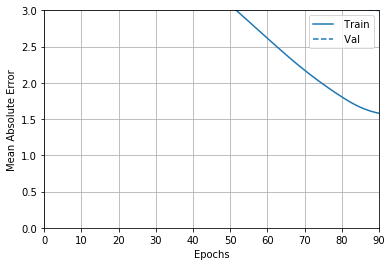

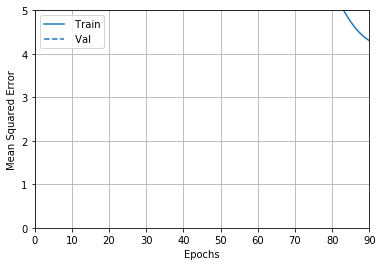

12742/1 - 0s - loss: 28.7283 - mae: 2.4016 - mse: 56.8771
Validation loss: 56.91778097676999
Mean absolute error: 2.4016185
Mean squared error: 56.877075
Average distance error: 4.060839403308657


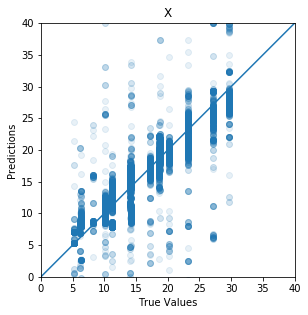

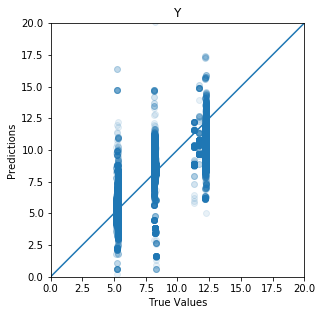


18771/1 - 0s - loss: 51.5533 - mae: 2.9926 - mse: 101.2023
Test loss: 101.24306559692238
Mean absolute error: 2.9925842
Mean squared error: 101.20232
Average distance error: 5.083507186818184


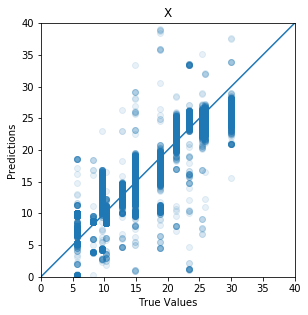

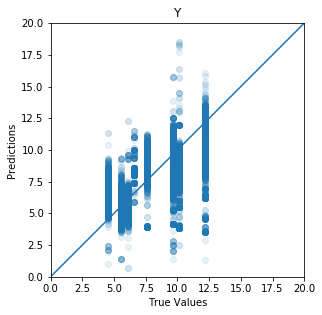


Rolling Window: 30

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all
Train on 50965 samples, validate on 18771 samples
Epoch 1/10000
50965/50965 [==============================] - 2s 49us/sample - loss: 198.2902 - mae: 11.8287 - mse: 198.2670 - val_loss: 205.4619 - val_mae: 12.3076 - val_mse: 205.4388
Epoch 2/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 190.3697 - mae: 11.4965 - mse: 190.3466 - val_loss: 192.6927 - val_mae: 11.8195 - val_mse: 192.6696
Epoch 3/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 183.7402 - mae: 11.1854 - mse: 183.7169 - val_loss: 181.6118 - val_mae: 11.3855 - val_mse: 181.5886
Epoch 4/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 177.8316 - mae: 10.9419 - mse: 177.8084 - val_loss: 172.0327 - val_mae: 10.9675 - val_mse: 172.0092
Epoch 5/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 172.3448 - mae: 10.72

50965/50965 [==============================] - 2s 35us/sample - loss: 15.4916 - mae: 3.1475 - mse: 15.4608 - val_loss: 22.9812 - val_mae: 3.4175 - val_mse: 22.9503
Epoch 46/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 14.9825 - mae: 3.1021 - mse: 14.9515 - val_loss: 23.0205 - val_mae: 3.3889 - val_mse: 22.9895
Epoch 47/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 14.4799 - mae: 3.0580 - mse: 14.4488 - val_loss: 23.1359 - val_mae: 3.3604 - val_mse: 23.1047
Epoch 48/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 13.9852 - mae: 3.0118 - mse: 13.9540 - val_loss: 23.1663 - val_mae: 3.3300 - val_mse: 23.1349
Epoch 49/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 13.4982 - mae: 2.9683 - mse: 13.4668 - val_loss: 23.1661 - val_mae: 3.2982 - val_mse: 23.1346
Epoch 50/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 13.0215 - mae: 2.9220 - mse: 12.990

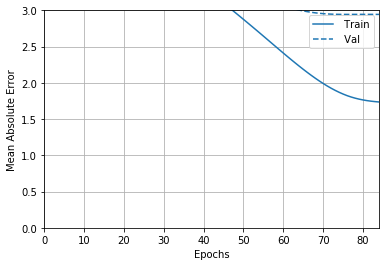

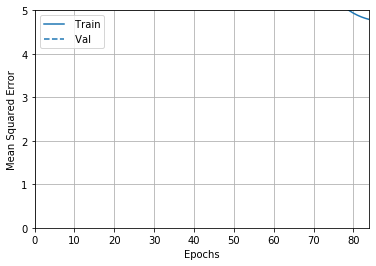

12742/1 - 0s - loss: 13.6894 - mae: 2.4481 - mse: 26.7723
Validation loss: 26.810122732604583
Mean absolute error: 2.4481308
Mean squared error: 26.772282
Average distance error: 3.96132038431577


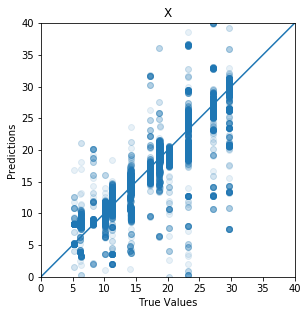

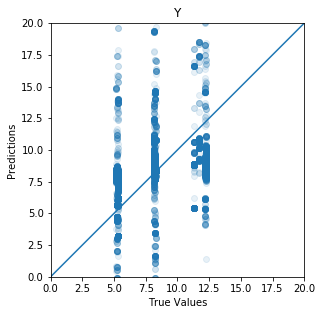


18771/1 - 0s - loss: 26.0128 - mae: 2.9416 - mse: 45.6143
Test loss: 45.652202429422644
Mean absolute error: 2.9416435
Mean squared error: 45.614346
Average distance error: 4.7855189423368385


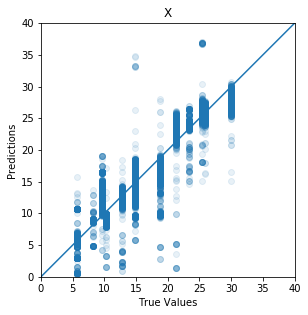

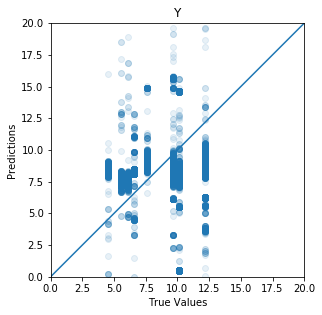


Rolling Window: 50

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all
Train on 50965 samples, validate on 18771 samples
Epoch 1/10000
50965/50965 [==============================] - 2s 46us/sample - loss: 383.9443 - mae: 15.0915 - mse: 383.9200 - val_loss: 416.6370 - val_mae: 16.5819 - val_mse: 416.6123
Epoch 2/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 321.8757 - mae: 14.2289 - mse: 321.8512 - val_loss: 332.0872 - val_mae: 14.9504 - val_mse: 332.0627
Epoch 3/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 275.6056 - mae: 13.4796 - mse: 275.5812 - val_loss: 270.8468 - val_mae: 13.7296 - val_mse: 270.8221
Epoch 4/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 238.0399 - mae: 12.7466 - mse: 238.0152 - val_loss: 225.0487 - val_mae: 12.5982 - val_mse: 225.0241
Epoch 5/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 206.8627 - mae: 12.00

50965/50965 [==============================] - 2s 35us/sample - loss: 13.4314 - mae: 2.9262 - mse: 13.3971 - val_loss: 20.1817 - val_mae: 3.1361 - val_mse: 20.1473
Epoch 46/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 12.8736 - mae: 2.8707 - mse: 12.8390 - val_loss: 19.2195 - val_mae: 3.0772 - val_mse: 19.1848
Epoch 47/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 12.3518 - mae: 2.8175 - mse: 12.3170 - val_loss: 18.4222 - val_mae: 3.0252 - val_mse: 18.3873
Epoch 48/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 11.8538 - mae: 2.7645 - mse: 11.8188 - val_loss: 17.6995 - val_mae: 2.9761 - val_mse: 17.6644
Epoch 49/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 11.3665 - mae: 2.7132 - mse: 11.3314 - val_loss: 17.0865 - val_mae: 2.9284 - val_mse: 17.0512
Epoch 50/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 10.8876 - mae: 2.6579 - mse: 10.852

50965/50965 [==============================] - 2s 34us/sample - loss: 3.3617 - mae: 1.3336 - mse: 3.3170 - val_loss: 13.9961 - val_mae: 2.1676 - val_mse: 13.9513
Epoch 92/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 3.3274 - mae: 1.3236 - mse: 3.2825 - val_loss: 13.9419 - val_mae: 2.1692 - val_mse: 13.8970
Epoch 93/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 3.2941 - mae: 1.3145 - mse: 3.2491 - val_loss: 13.8982 - val_mae: 2.1693 - val_mse: 13.8531
Epoch 94/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 3.2608 - mae: 1.3050 - mse: 3.2157 - val_loss: 13.8514 - val_mae: 2.1695 - val_mse: 13.8062
Epoch 95/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 3.2288 - mae: 1.2975 - mse: 3.1836 - val_loss: 13.7451 - val_mae: 2.1681 - val_mse: 13.6997
Epoch 96/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 3.2007 - mae: 1.2893 - mse: 3.1553 - val_loss

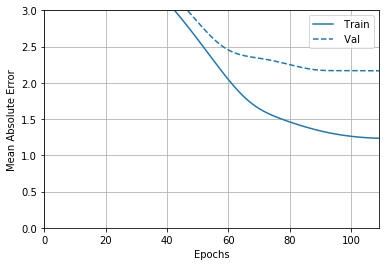

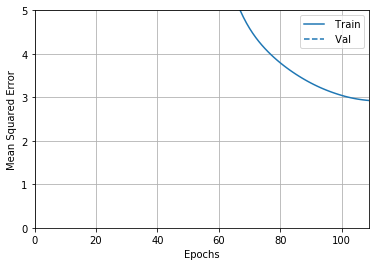

12742/1 - 0s - loss: 7.4971 - mae: 2.0350 - mse: 14.0212
Validation loss: 14.067707357330274
Mean absolute error: 2.0349588
Mean squared error: 14.021212
Average distance error: 3.2664925918400387


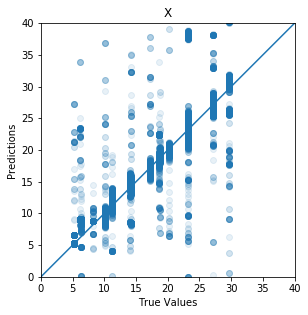

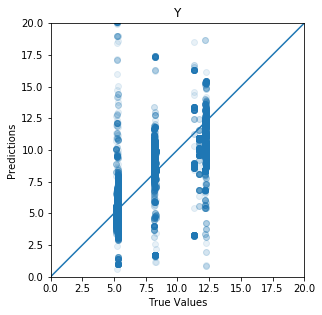


18771/1 - 0s - loss: 8.0713 - mae: 2.1613 - mse: 12.9144
Test loss: 12.96087845678392
Mean absolute error: 2.161266
Mean squared error: 12.91438
Average distance error: 3.4375488091701065


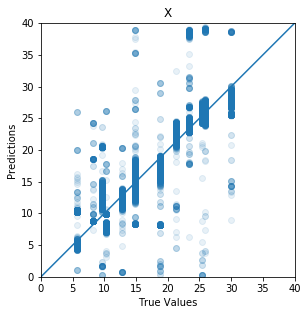

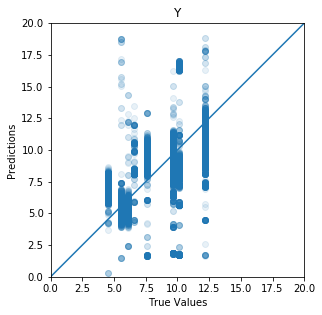


Rolling Window: 100

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all
Train on 50965 samples, validate on 18771 samples
Epoch 1/10000
50965/50965 [==============================] - 2s 46us/sample - loss: 591.4017 - mae: 18.5371 - mse: 591.3755 - val_loss: 702.9344 - val_mae: 18.9516 - val_mse: 702.9083
Epoch 2/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 461.6777 - mae: 16.6634 - mse: 461.6519 - val_loss: 578.5585 - val_mae: 17.4694 - val_mse: 578.5323
Epoch 3/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 371.6738 - mae: 15.0737 - mse: 371.6483 - val_loss: 484.1845 - val_mae: 16.2869 - val_mse: 484.1585
Epoch 4/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 309.8341 - mae: 13.8216 - mse: 309.8082 - val_loss: 410.5142 - val_mae: 15.2597 - val_mse: 410.4884
Epoch 5/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 266.6367 - mae: 12.8

50965/50965 [==============================] - 2s 35us/sample - loss: 16.9414 - mae: 3.1680 - mse: 16.9079 - val_loss: 32.2664 - val_mae: 3.4977 - val_mse: 32.2328
Epoch 46/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 16.4339 - mae: 3.1231 - mse: 16.4003 - val_loss: 32.4767 - val_mae: 3.4660 - val_mse: 32.4430
Epoch 47/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 15.9330 - mae: 3.0790 - mse: 15.8992 - val_loss: 32.6623 - val_mae: 3.4383 - val_mse: 32.6285
Epoch 48/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 15.4417 - mae: 3.0336 - mse: 15.4078 - val_loss: 33.0142 - val_mae: 3.4165 - val_mse: 32.9802
Epoch 49/10000
50965/50965 [==============================] - 2s 35us/sample - loss: 14.9593 - mae: 2.9901 - mse: 14.9252 - val_loss: 33.1654 - val_mae: 3.3894 - val_mse: 33.1313
Epoch 50/10000
50965/50965 [==============================] - 2s 34us/sample - loss: 14.4826 - mae: 2.9448 - mse: 14.448

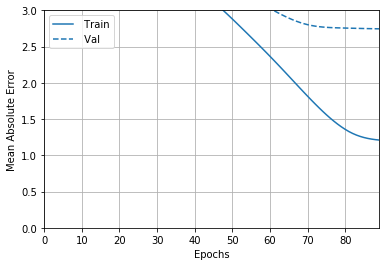

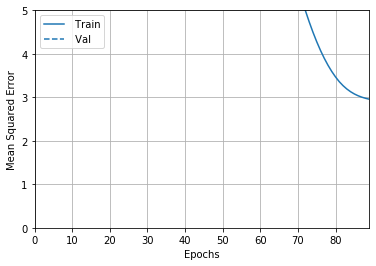

12742/1 - 0s - loss: 17.3416 - mae: 2.3644 - mse: 34.1968
Validation loss: 34.24102643954101
Mean absolute error: 2.3644445
Mean squared error: 34.19677
Average distance error: 3.7515998820421936


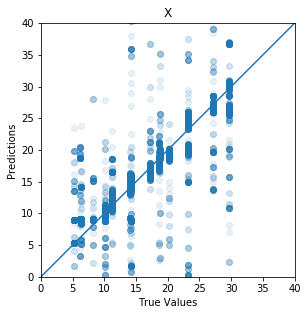

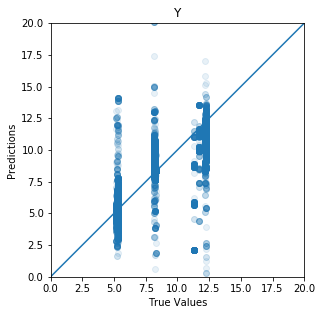


18771/1 - 0s - loss: 26.7133 - mae: 2.7385 - mse: 50.6538
Test loss: 50.69808167015621
Mean absolute error: 2.738534
Mean squared error: 50.653793
Average distance error: 4.1653795802100575


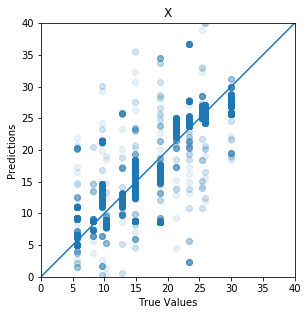

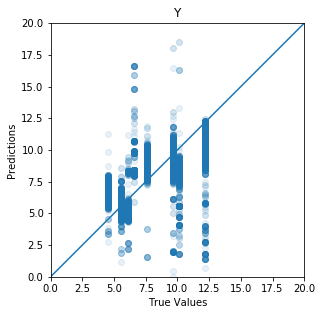

In [36]:
validation_error = []
test_error = []

for i in [10, 30, 50, 100]:
    
    print()
    print('=' * 20)
    print('Rolling Window: {}'.format(i))
    print('=' * 20)
    print()
    
    data = read_data("../Data/rssi_2.csv")
    data[scanners] = min_max_scaling(data[scanners])

    test = read_data("../Data/testRssi_2.csv")
    test[scanners] = min_max_scaling(test[scanners])

    ## Train Validation Split

    train, validation = train_validation_split(data)
    train.sort_values("time", inplace=True)
    validation.sort_values("time", inplace=True)
    test.sort_values("time", inplace=True)

    rolling_win = i
    train_rolled = train.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    validation_rolled = validation.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    test_rolled = test.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()

    ## Imputation
    
    train_imputed = train_rolled.set_index("location").groupby("location").ffill()
    train_imputed.reset_index(inplace=True)
    
    validation_imputed = validation_rolled.set_index("location").groupby("location").ffill()
    validation_imputed.reset_index(inplace=True)

    test_imputed = test_rolled.set_index("location").groupby("location").ffill()
    test_imputed.reset_index(inplace=True)

    ## Change Location to Coordinates

    train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
    train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

    validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
    validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

    test_imputed["X"] = test_imputed["location"].apply(lambda x: testPin[x]["X"])
    test_imputed["Y"] = test_imputed["location"].apply(lambda x: testPin[x]["Y"])

    ## Linear Imputation

    linear_impute(train_imputed)
    linear_impute(validation_imputed)
    linear_impute(test_imputed)

    ## Model Training

    X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
    X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
    X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values
    
    ## Create Model
    
    optimizer = tf.keras.optimizers.Adam(0.00001)
    loss = "mse"
    metrics = ["mae", "mse"]
    batch_size = 32
    epochs = 10000

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss')
    ]

    inputs = tf.keras.Input(shape=(17,))
    x = tf.keras.layers.Dense(16, activation='relu')(inputs)
    x = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

    y = tf.keras.layers.Dense(16, activation='relu')(inputs)
    y = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
    y = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)

    outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    plt.figure()
    plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
    plotter.plot({"": history}, metric = "mae")
    plt.ylim([0, 3])
    plt.ylabel('Mean Absolute Error')

    plt.figure()
    plotter.plot({"": history}, metric = "mse")
    plt.ylim([0, 5])
    plt.ylabel('Mean Squared Error')
    
    plt.show()

    ## Model Validation

    validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
    print("Validation loss:", validation_scores[0])
    print("Mean absolute error:", validation_scores[1])
    print("Mean squared error:", validation_scores[2])

    preds = model.predict(X_validation)
    validation_avg_derror = average_distance_error(preds, y_validation)
    print("Average distance error:", validation_avg_derror)
        
    validation_error.append((validation_scores[2], validation_avg_derror))

    fig = plt.figure(figsize=(10, 20))
    lims = [0, 40]
    ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
    ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
    ax1.plot(lims, lims)

    fig = plt.figure(figsize=(10, 20))
    lims = [0, 20]
    ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
    ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
    ax1.plot(lims, lims)

    plt.show()
    print()
    
    ## Model Testing

    test_scores = model.evaluate(X_test, y_test, verbose=2)
    print("Test loss:", test_scores[0])
    print("Mean absolute error:", test_scores[1])
    print("Mean squared error:", test_scores[2])

    preds = model.predict(X_test)
    test_avg_derror = average_distance_error(preds, y_test)
    print("Average distance error:", test_avg_derror)
    
    test_error.append((test_scores[2], test_avg_derror))

    fig = plt.figure(figsize=(10, 20))
    lims = [0, 40]
    ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
    ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
    ax1.plot(lims, lims)

    fig = plt.figure(figsize=(10, 20))
    lims = [0, 20]
    ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

    ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
    ax1.plot(lims, lims)

    plt.show()